# Прогнозирование оттока клиентов телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

**Задача** - спрогнозировать отток клиентов. Построить модель со значением ROC-AUC не ниже 0.88

## Импорты

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Загрузка и первичный просмотр данных 

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [4]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


На этапе первичного анализа мы увидели, что неообходимо 
* переименовать столбцы
* привести часть столбцов к нужным типам
* закодировать некоторые столбцы

Пропусков в данных обнаружено не было. Но видим, что в таблицах internet и phone данных меньше. Скорее всего, не все клиенты используют эти услуги

Помимо этого, нужно будет объединить таблицы в один датасет, поскольку данных не так много

Кроме того, нужно добавить колонку, показывающую факт ухода клиента, который мы предсказываем.

## Предобработка и исследование

Для начала объединим все таблицы в один датафрейм

In [14]:
contract.set_index('customerID', drop=True, inplace=True)
personal.set_index('customerID', drop=True, inplace=True)
internet.set_index('customerID', drop=True, inplace=True)
phone.set_index('customerID', drop=True, inplace=True)

In [15]:
df = contract.join(personal, how='left').join(internet, how='left').join(phone, how='left')


In [16]:
gone = df.loc[df['EndDate'] != 'No']
stayed = df.loc[df['EndDate'] == 'No']

In [17]:
stayed

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1419.4,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


Теперь добавим целевой признак

In [18]:
df['churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Переименуем для удобства названия столбцов

In [19]:
df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'churn'],
      dtype='object')

In [20]:
df = df.rename({'BeginDate': 'begin_date', 
                'EndDate': 'end_date', 
                'Type': 'type', 
                'PaperlessBilling': 'paperless_billing', 
                'PaymentMethod': 'payment_method', 
                'MonthlyCharges': 'monthly_charges', 
                'TotalCharges': 'total_charges',
                'SeniorCitizen': 'senior_citizen', 
                'Partner': 'partner', 
                'Dependents': 'dependents',
                'InternetService': 'internet_service',
                'OnlineSecurity': 'online_security',
                'OnlineBackup': 'online_backup',
                'DeviceProtection': 'device_protection',
                'TechSupport': 'tech_support',
                'StreamingTV': 'streaming_tv',
                'StreamingMovies': 'streaming_movies',
                'MultipleLines': 'multiple_lines'},  axis=1)

In [21]:
gone = gone.rename({'BeginDate': 'begin_date', 
                'EndDate': 'end_date', 
                'Type': 'type', 
                'PaperlessBilling': 'paperless_billing', 
                'PaymentMethod': 'payment_method', 
                'MonthlyCharges': 'monthly_charges', 
                'TotalCharges': 'total_charges',
                'SeniorCitizen': 'senior_citizen', 
                'Partner': 'partner', 
                'Dependents': 'dependents',
                'InternetService': 'internet_service',
                'OnlineSecurity': 'online_security',
                'OnlineBackup': 'online_backup',
                'DeviceProtection': 'device_protection',
                'TechSupport': 'tech_support',
                'StreamingTV': 'streaming_tv',
                'StreamingMovies': 'streaming_movies',
                'MultipleLines': 'multiple_lines'},  axis=1)

In [22]:
stayed = stayed.rename({'BeginDate': 'begin_date', 
                'EndDate': 'end_date', 
                'Type': 'type', 
                'PaperlessBilling': 'paperless_billing', 
                'PaymentMethod': 'payment_method', 
                'MonthlyCharges': 'monthly_charges', 
                'TotalCharges': 'total_charges',
                'SeniorCitizen': 'senior_citizen', 
                'Partner': 'partner', 
                'Dependents': 'dependents',
                'InternetService': 'internet_service',
                'OnlineSecurity': 'online_security',
                'OnlineBackup': 'online_backup',
                'DeviceProtection': 'device_protection',
                'TechSupport': 'tech_support',
                'StreamingTV': 'streaming_tv',
                'StreamingMovies': 'streaming_movies',
                'MultipleLines': 'multiple_lines'},  axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

#### churn

Посмотрим на целевой признак

In [24]:
df['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

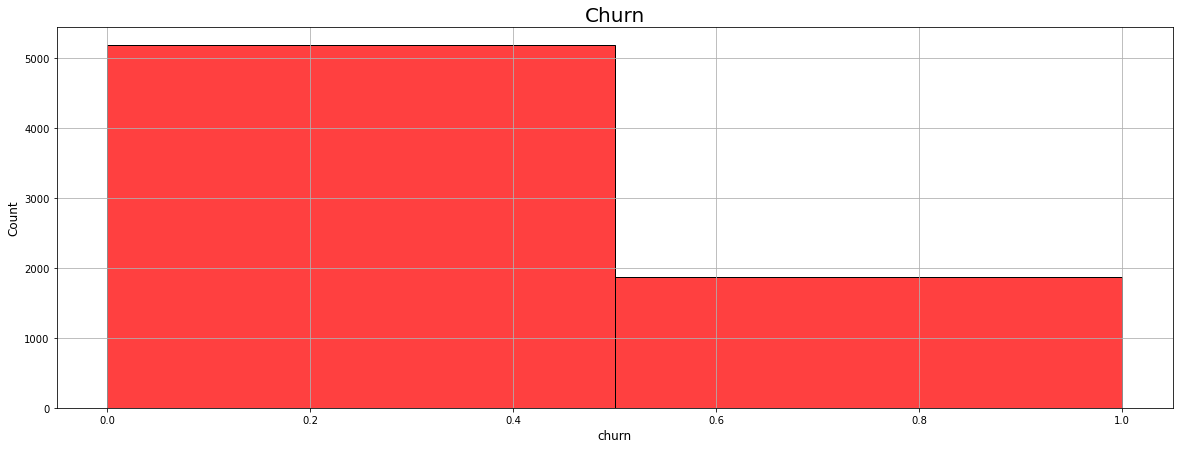

In [25]:
plt.figure(figsize=(20, 7))
plt.title('Churn', fontsize=20)
sns.histplot(df['churn'], color='r', kde=False, bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('churn', fontsize=12)
plt.grid(True);

Видим значительный перевес в сторону не ушедших клиентов. 

Итак, данные несбалансированы. Это надо будет учитывать при построении модели.

Теперь посмотрим, что делать с остальными фичами

#### begin_date

Дата начала пользования услугами. Её скорее всего нужно перевести в формат datetime

In [26]:
df['begin_date'] =  pd.to_datetime(df['begin_date'])

In [27]:
df['begin_date'].describe()

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_528\3692557974.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['begin_date'].describe()


count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begin_date, dtype: object

#### end_date

In [28]:
df['end_date']

customerID
7590-VHVEG                     No
5575-GNVDE                     No
3668-QPYBK    2019-12-01 00:00:00
7795-CFOCW                     No
9237-HQITU    2019-11-01 00:00:00
                     ...         
6840-RESVB                     No
2234-XADUH                     No
4801-JZAZL                     No
8361-LTMKD    2019-11-01 00:00:00
3186-AJIEK                     No
Name: end_date, Length: 7043, dtype: object

Поскольку данные актуальны на период 1 февраля 2020 года, добавим эту дату вместо No

In [29]:
df['end_date'] = df['end_date'].where(df['end_date'] != 'No', '2020-02-01')

In [30]:
df['end_date'] =  pd.to_datetime(df['end_date'])

In [31]:
df['end_date'].describe()

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_528\631191076.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['end_date'].describe()


count                    7043
unique                      5
top       2020-02-01 00:00:00
freq                     5174
first     2019-10-01 00:00:00
last      2020-02-01 00:00:00
Name: end_date, dtype: object

#### period

Добавим столбец с периодом 

In [32]:
df['period'] = (df['end_date'] - df['begin_date']).dt.days

In [33]:
df['period'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: period, dtype: float64

#### type

Тип договора: ежемесячный, годовой и т.д

In [34]:
df['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

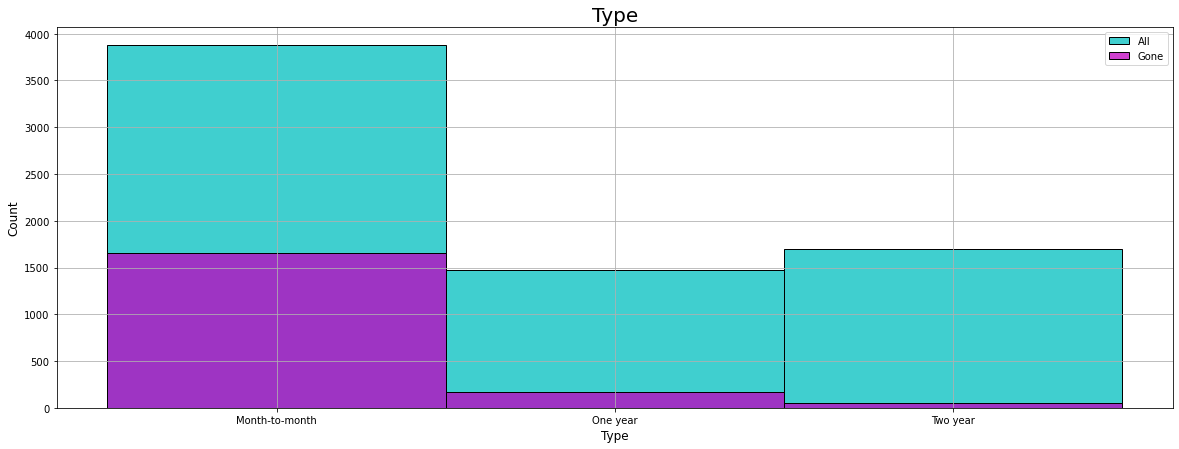

In [35]:
plt.figure(figsize=(20, 7))
plt.title('Type', fontsize=20)
sns.histplot(df['type'], color='c', kde=False, label='All');
sns.histplot(gone['type'], color='m', kde=False, label='Gone');
plt.ylabel('Count', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.legend()

plt.grid(True);

На гистограмме видно, что в целом, клиенты чаще пользуются ежемесячным договором. По другим типам договоров можно сказать, что среди ушедших клиентов доля тех, кто пользовался годовым договором выше, чем двугодовым, в то время как по данным всех клиентов мы видимм обратную ситуацию.

#### paperless_billing

Факт выставления счёта на электронную почту

In [36]:
df['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Перекодируем этот столбец

In [37]:
df['paperless_billing'] = df['paperless_billing'].map({'No' : 0, 'Yes' : 1})

In [38]:
gone['paperless_billing'] = gone['paperless_billing'].map({'No' : 0, 'Yes' : 1})

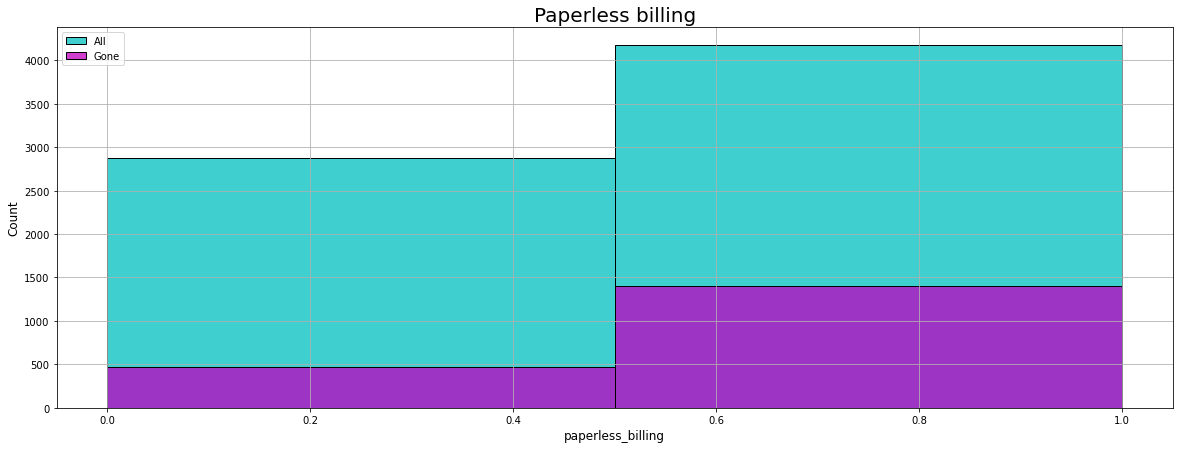

In [39]:
plt.figure(figsize=(20, 7))
plt.title('Paperless billing', fontsize=20)
sns.histplot(df['paperless_billing'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['paperless_billing'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('paperless_billing', fontsize=12)
plt.legend()

plt.grid(True);

По факту выставления счёта на электронную почту ушедшие клиенты практически не отличаются от всех

#### payment_method

In [40]:
df['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

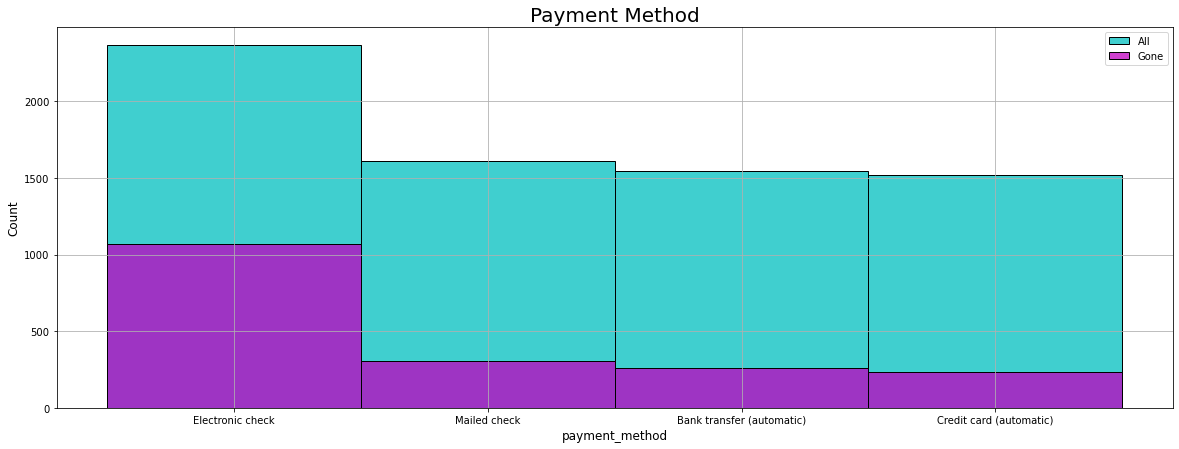

In [41]:
plt.figure(figsize=(20, 7))
plt.title('Payment Method', fontsize=20)
sns.histplot(df['payment_method'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['payment_method'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method', fontsize=12)
plt.legend()

plt.grid(True);

Мы видим, что больщинство клиентов в качестве способа оплаты используют электронный чек. Распределения для ушедших клиентов и для всех схожи

#### monthly_charges

In [42]:
df['monthly_charges'].value_counts()

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: monthly_charges, Length: 1585, dtype: int64

C:\Users\Anastasia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Anastasia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


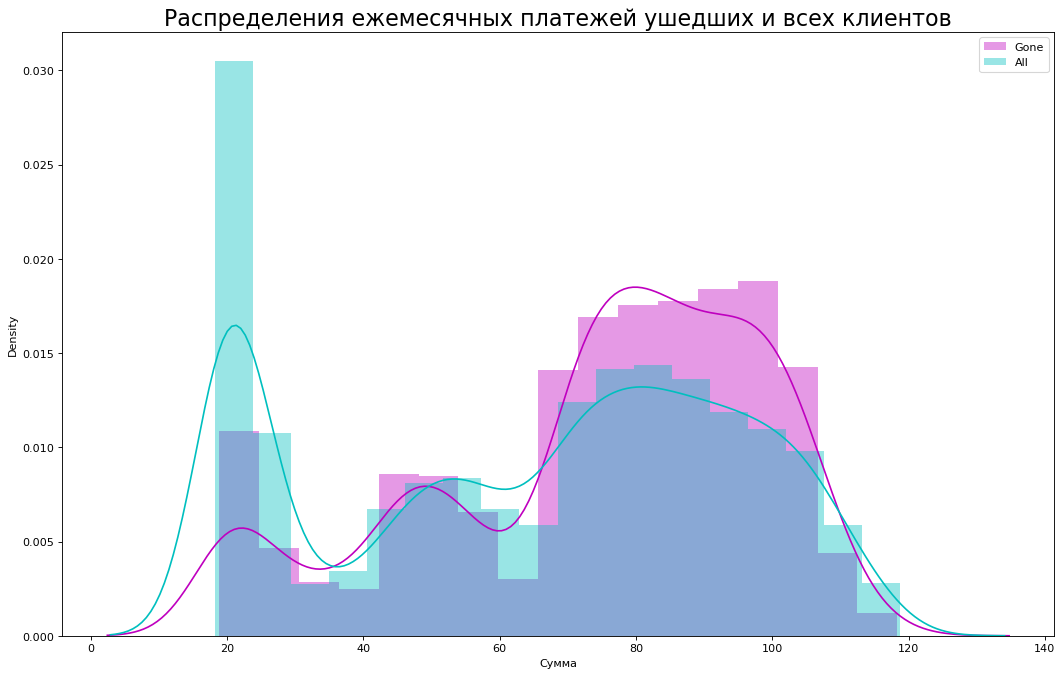

In [43]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(gone['monthly_charges'], color="m", label="Gone")
sns.distplot(df['monthly_charges'], color="c", label="All")

plt.title('Распределения ежемесячных платежей ушедших и всех клиентов', fontsize=20)
plt.legend()
plt.xlabel('Сумма')
plt.show()

На графике видны три пика - наверное, три разных тарифа. Мы видим, что на пике, находящемся посередине ушедших клиентов и всех примерно одинаково. На пике с наименьшим значением ушедших клиентов гораздо меньше, а на пике с наибольшим значением - гораздо больше. Можем сказать, что клиенты, которые ежемесячно платят больше, уходят чаще. 

#### total_charges

Всего потрачено денег на услуги

In [44]:
df['total_charges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

Видим значение "", встречающиеся 11 раз. Судя по всему из-за него тип данных в этом столбце object, а не float. Посмотрим, в каких строках встречается это значение

In [45]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df[df['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,period
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,Male,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,NaN,Female,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0


Удалим эти пропуски. Посокльку т.к. эти клиенты начали использовать услуги в день сбора данных, по ним у нас нет толком информации

In [46]:
df.dropna(subset=['total_charges'], inplace=True)

C:\Users\Anastasia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Anastasia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


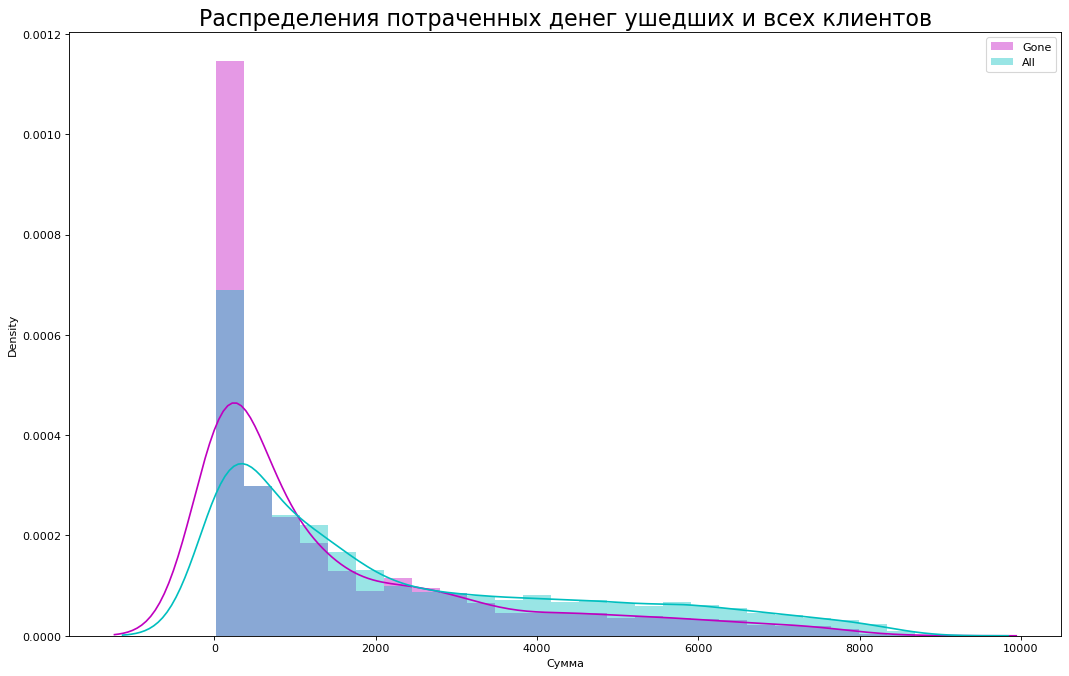

In [47]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(gone['total_charges'], color="m", label="Gone")
sns.distplot(df['total_charges'], color="c", label="All")

plt.title('Распределения потраченных денег ушедших и всех клиентов', fontsize=20)
plt.legend()
plt.xlabel('Сумма')
plt.show()

Видим примерно равные картины для ушедших клиентов и для всех - пик в районе нуля и длинный хвост вправо

#### gender

In [48]:
df['gender'].value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64

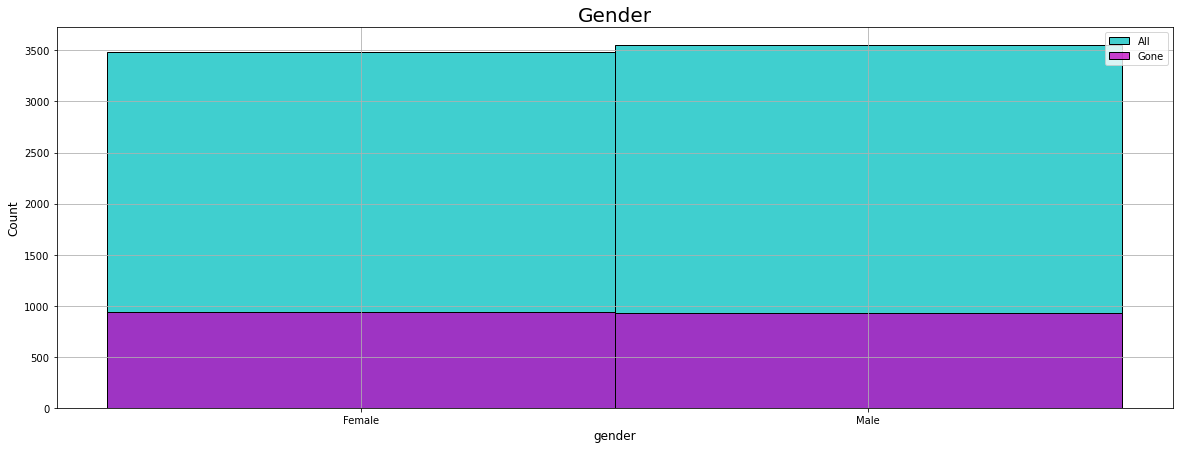

In [49]:
plt.figure(figsize=(20, 7))
plt.title('Gender', fontsize=20)
sns.histplot(df['gender'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['gender'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('gender', fontsize=12)
plt.legend()

plt.grid(True);

Видим, что по гендеру нет разницы - и мужчин и женщин одинаковое количество в обеих группах

#### senior_citizen     

Наличие пенсионного статуса по возрасту

In [50]:
df['senior_citizen'].value_counts()

0    5890
1    1142
Name: senior_citizen, dtype: int64

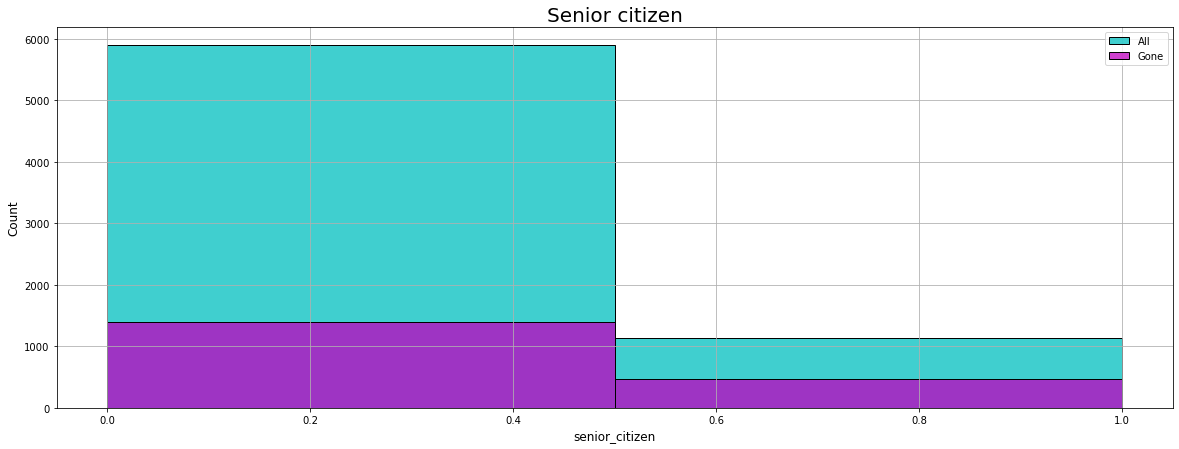

In [51]:
plt.figure(figsize=(20, 7))
plt.title('Senior citizen', fontsize=20)
sns.histplot(df['senior_citizen'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['senior_citizen'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('senior_citizen', fontsize=12)
plt.legend()

plt.grid(True);

Пенсионный статус по возрасту по гистограмме вообще не влияет на факт ухода клиента. Распределения одинаковые для обеих групп

#### partner

In [52]:
df['partner'].value_counts()

No     3639
Yes    3393
Name: partner, dtype: int64

Перекодируем этот столбец

In [53]:
df['partner'] = df['partner'].map({'No' : 0, 'Yes' : 1})

In [54]:
gone['partner'] = gone['partner'].map({'No' : 0, 'Yes' : 1})

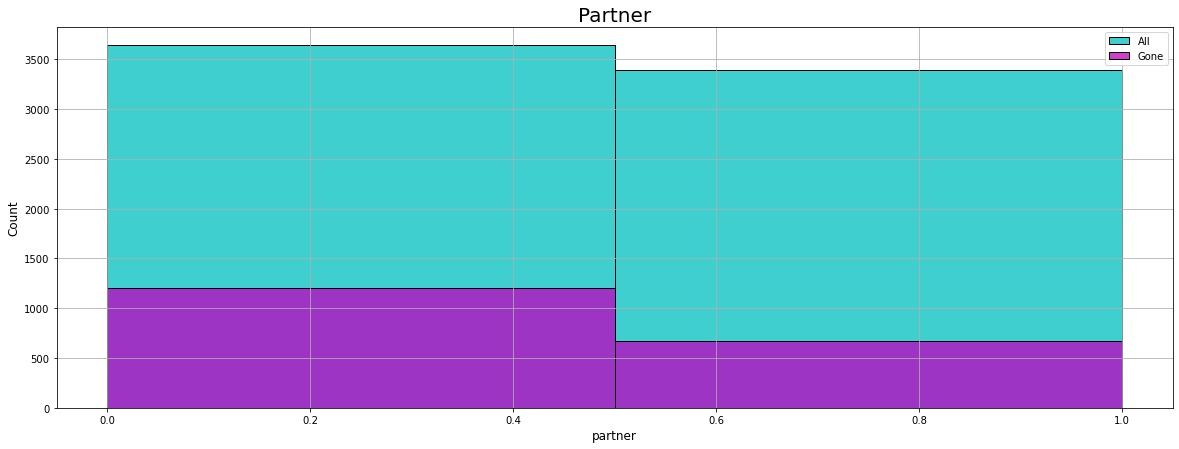

In [55]:
plt.figure(figsize=(20, 7))
plt.title('Partner', fontsize=20)
sns.histplot(df['partner'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['partner'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('partner', fontsize=12)
plt.legend()

plt.grid(True);

Налисие супруга(и) судя по гистограме не влияет на факт ухода клиента. Распределения практически идентичные

#### dependents

наличие иждивенцев

In [56]:
df['dependents'].value_counts()

No     4933
Yes    2099
Name: dependents, dtype: int64

In [57]:
df['dependents'] = df['dependents'].map({'No' : 0, 'Yes' : 1})

In [58]:
gone['dependents'] = gone['dependents'].map({'No' : 0, 'Yes' : 1})

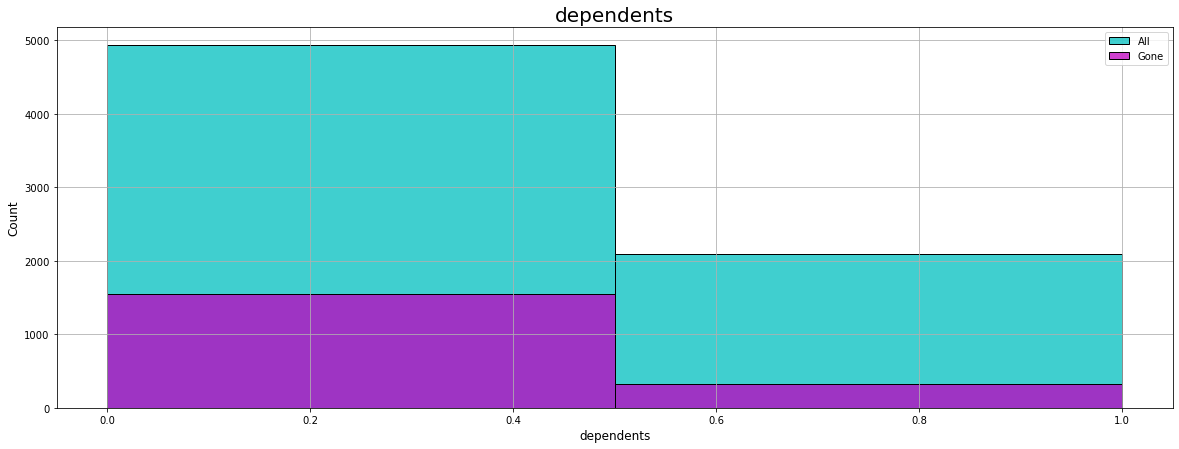

In [59]:
plt.figure(figsize=(20, 7))
plt.title('dependents', fontsize=20)
sns.histplot(df['dependents'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['dependents'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('dependents', fontsize=12)
plt.legend()

plt.grid(True);

Среди ушедших клиентов имеющих иждивенцев совсем мало. Этот признак скорее всего не будет значимым

#### internet_service

In [60]:
df['internet_service'].value_counts()

Fiber optic    3096
DSL            2416
Name: internet_service, dtype: int64

In [61]:
df['internet_service'] = df['internet_service'].fillna('No')

In [62]:
gone['internet_service'] = gone['internet_service'].fillna('No')

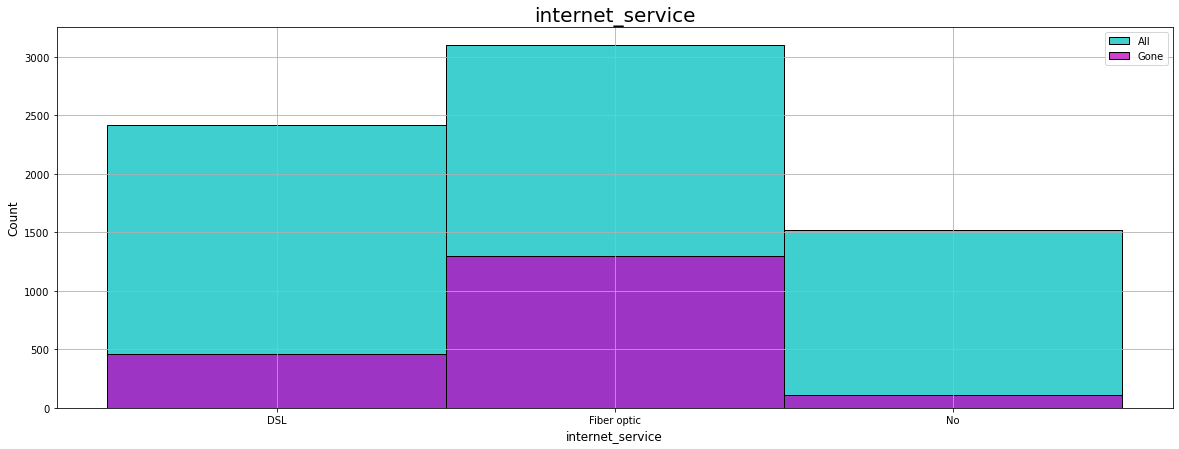

In [63]:
plt.figure(figsize=(20, 7))
plt.title('internet_service', fontsize=20)
sns.histplot(df['internet_service'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['internet_service'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('internet_service', fontsize=12)
plt.legend()

plt.grid(True);

Распределения практически не отличаются. Можно отметить, что ушедших клиентов, не пользовавшихся этой услугой очень мало. 

#### online_security

In [64]:
df['online_security'].value_counts()

No     3497
Yes    2015
Name: online_security, dtype: int64

In [65]:
df['online_security'] = df['online_security'].map({'No' : 0, 'Yes' : 1})

In [66]:
gone['online_security'] = gone['online_security'].map({'No' : 0, 'Yes' : 1})

In [67]:
df['online_security'] = df['online_security'].fillna(0)

In [68]:
gone['online_security'] = gone['online_security'].fillna(0)

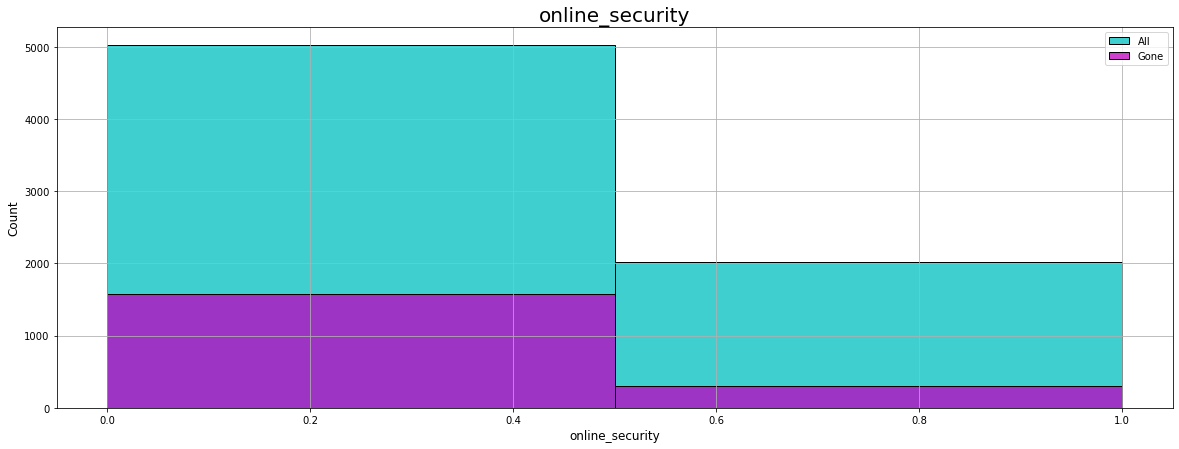

In [69]:
plt.figure(figsize=(20, 7))
plt.title('online_security', fontsize=20)
sns.histplot(df['online_security'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['online_security'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('online_security', fontsize=12)
plt.legend()

plt.grid(True);

Ушедших клиентов, пользовавшихся услугой интернет-безопасности гораздо меньше. Но в целом распределения похожи

#### online_backup

In [70]:
df['online_backup'].value_counts()

No     3087
Yes    2425
Name: online_backup, dtype: int64

In [71]:
df['online_backup'] = df['online_backup'].map({'No' : 0, 'Yes' : 1})

In [72]:
gone['online_backup'] = gone['online_backup'].map({'No' : 0, 'Yes' : 1})

In [73]:
df['online_backup'] = df['online_backup'].fillna(0)

In [74]:
gone['online_backup'] = gone['online_backup'].fillna(0)

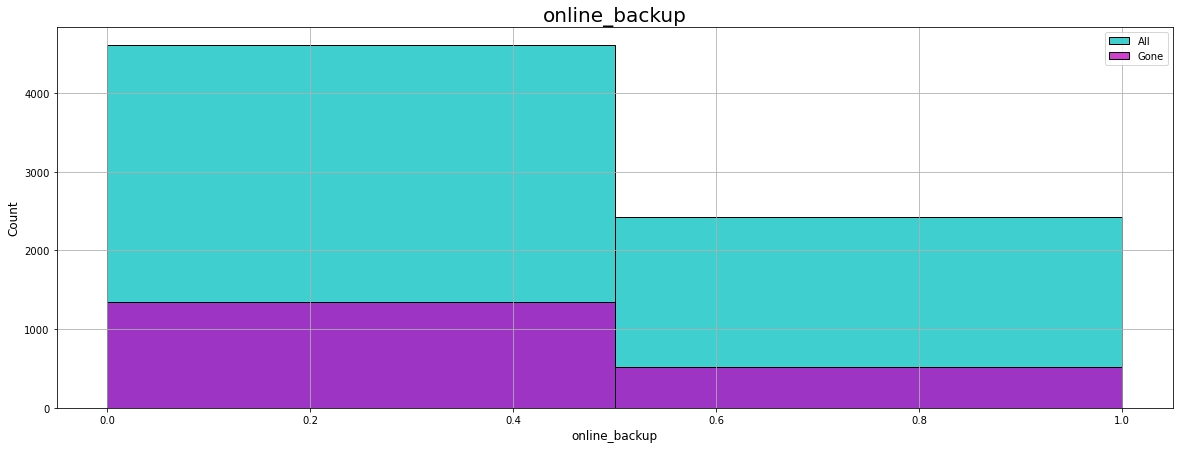

In [75]:
plt.figure(figsize=(20, 7))
plt.title('online_backup', fontsize=20)
sns.histplot(df['online_backup'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['online_backup'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('online_backup', fontsize=12)
plt.legend()

plt.grid(True);

Видим практически одинаковые распределения для ушедших клиентов и для всех

#### device_protection

In [76]:
df['device_protection'].value_counts()

No     3094
Yes    2418
Name: device_protection, dtype: int64

In [77]:
df['device_protection'] = df['device_protection'].map({'No' : 0, 'Yes' : 1})

In [78]:
gone['device_protection'] = gone['device_protection'].map({'No' : 0, 'Yes' : 1})

In [79]:
df['device_protection'] = df['device_protection'].fillna(0)

In [80]:
gone['device_protection'] = gone['device_protection'].fillna(0)

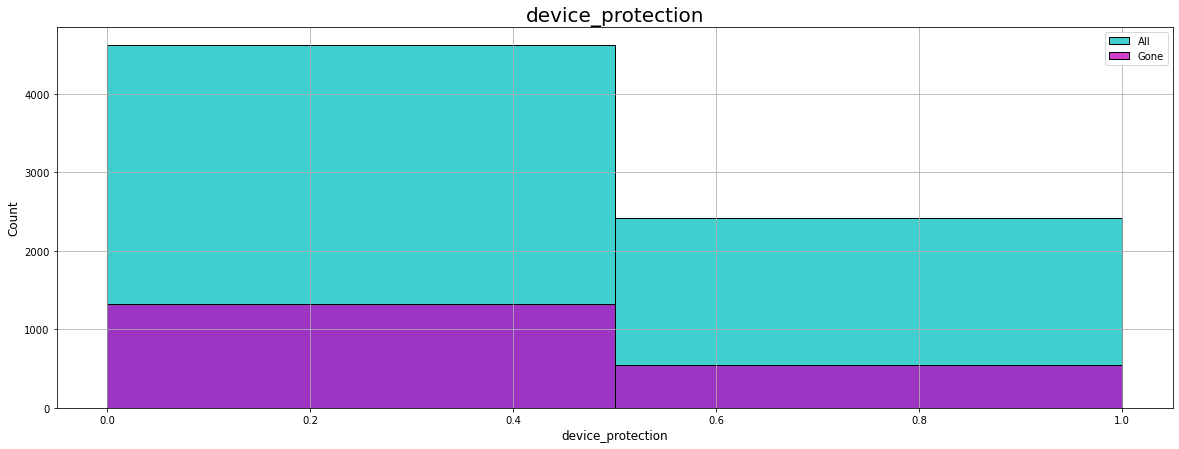

In [81]:
plt.figure(figsize=(20, 7))
plt.title('device_protection', fontsize=20)
sns.histplot(df['device_protection'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['device_protection'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('device_protection', fontsize=12)
plt.legend()

plt.grid(True);

Услугой антивируса ушедшие и все клиенты пользовались примерно одинаково

#### tech_support

In [82]:
df['tech_support'].value_counts()

No     3472
Yes    2040
Name: tech_support, dtype: int64

In [83]:
df['tech_support'] = df['tech_support'].map({'No' : 0, 'Yes' : 1})

In [84]:
gone['tech_support'] = gone['tech_support'].map({'No' : 0, 'Yes' : 1})

In [85]:
df['tech_support'] = df['tech_support'].fillna(0)

In [86]:
gone['tech_support'] = gone['tech_support'].fillna(0)

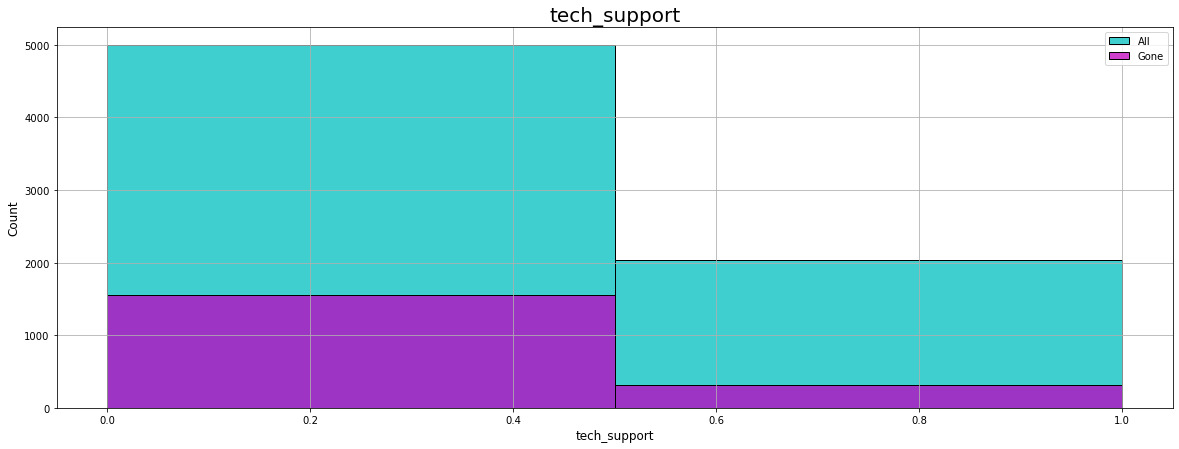

In [87]:
plt.figure(figsize=(20, 7))
plt.title('tech_support', fontsize=20)
sns.histplot(df['tech_support'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['tech_support'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('tech_support', fontsize=12)
plt.legend()

plt.grid(True);

Мы видим, что среди ушедших клиентов гораздо меньше тех, кто пользовался выделенной линией технической поддержки, сильно меньше, но в целом, распределения схожи.

#### streaming_tv 

In [88]:
df['streaming_tv'].value_counts()

No     2809
Yes    2703
Name: streaming_tv, dtype: int64

In [89]:
df['streaming_tv'] = df['streaming_tv'].map({'No' : 0, 'Yes' : 1})

In [90]:
gone['streaming_tv'] = gone['streaming_tv'].map({'No' : 0, 'Yes' : 1})

In [91]:
df['streaming_tv'] = df['streaming_tv'].fillna(0)

In [92]:
gone['streaming_tv'] = gone['streaming_tv'].fillna(0)

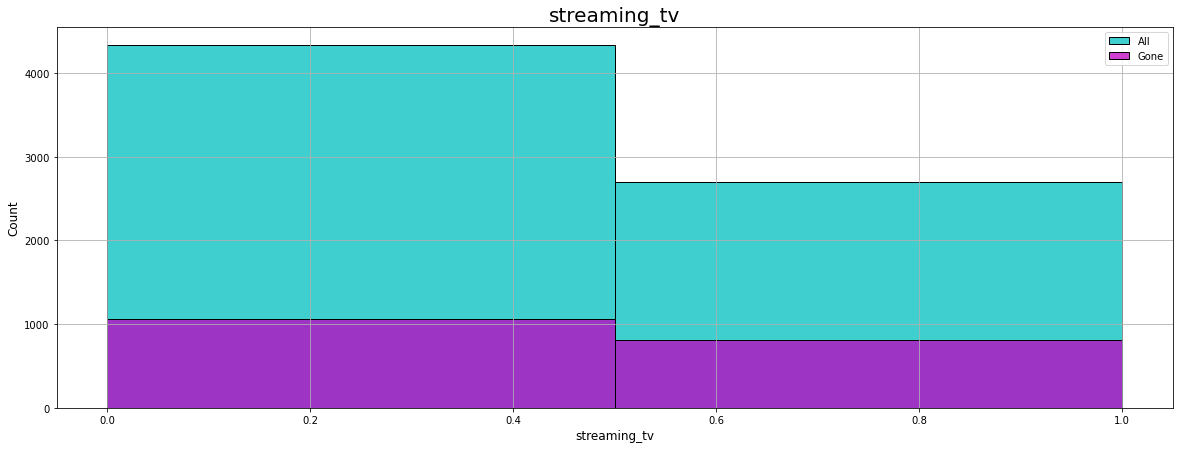

In [93]:
plt.figure(figsize=(20, 7))
plt.title('streaming_tv', fontsize=20)
sns.histplot(df['streaming_tv'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['streaming_tv'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('streaming_tv', fontsize=12)
plt.legend()

plt.grid(True);

Видим, что среди ушедших клиентов людей, пользовавшихся услугой стриммингового телевидения и не пользовавшихся ей, примерно поровну, в то время как среди всех клиентов распределения отличаются - тех, кто не пользовался заметно больше

#### streaming_movies

In [94]:
df['streaming_movies'].value_counts()

No     2781
Yes    2731
Name: streaming_movies, dtype: int64

In [95]:
df['streaming_movies'] = df['streaming_movies'].map({'No' : 0, 'Yes' : 1})

In [96]:
gone['streaming_movies'] = gone['streaming_movies'].map({'No' : 0, 'Yes' : 1})

In [97]:
df['streaming_movies'] = df['streaming_movies'].fillna(0)

In [98]:
gone['streaming_movies'] = gone['streaming_movies'].fillna(0)

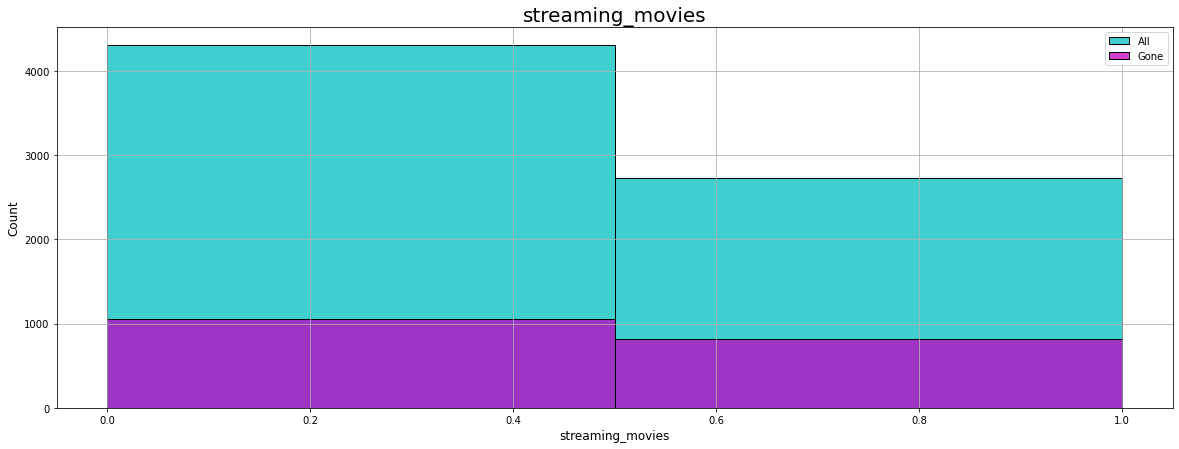

In [99]:
plt.figure(figsize=(20, 7))
plt.title('streaming_movies', fontsize=20)
sns.histplot(df['streaming_movies'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['streaming_movies'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('streaming_movies', fontsize=12)
plt.legend()

plt.grid(True);

С каталогами фильмов ситуация идентичная стриминговому телевидению - среди ушедших клиентов разница в классах заметна гораздо слабее, чем среди всех.

#### multiple_lines

In [100]:
df['multiple_lines'].value_counts()

No     3385
Yes    2967
Name: multiple_lines, dtype: int64

In [101]:
df['multiple_lines'] = df['multiple_lines'].map({'No' : 0, 'Yes' : 1})

In [102]:
gone['multiple_lines'] = gone['multiple_lines'].map({'No' : 0, 'Yes' : 1})

In [103]:
df['multiple_lines'] = df['multiple_lines'].fillna(0)

In [104]:
gone['multiple_lines'] = gone['multiple_lines'].fillna(0)

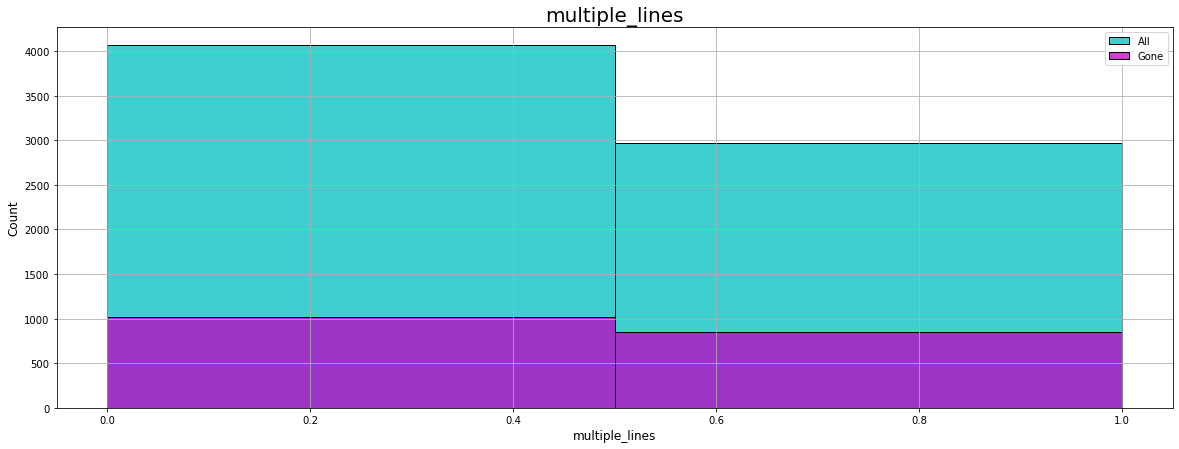

In [105]:
plt.figure(figsize=(20, 7))
plt.title('multiple_lines', fontsize=20)
sns.histplot(df['multiple_lines'], color='c', kde=False, label='All', bins=2);
sns.histplot(gone['multiple_lines'], color='m', kde=False, label='Gone', bins=2);
plt.ylabel('Count', fontsize=12)
plt.xlabel('multiple_lines', fontsize=12)
plt.legend()

plt.grid(True);

Аналогично - ситуация в целом схожая по классам среди ушедших клиентов и заметная разница между классами среди всех

## План

 * Разделить данные на обучающую и тестовую выборки
 * Закодировать категориальные переменные
 * Попробовать отмасштабировать значения
 * Протестировать разные наборы фичей
 * Обучить разные модели
   * В первую очередь бустинги, поскольку они лучше справляются с табличными данными, но можно попробовать и более простые модели вроде случайного леса
 * Подобрать гипер-параметры
 * Протестировать лучшую модель на тестовой выборке


## ML

Вспомним, какие фичи у нас есть

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   int64         
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   int64         
 9   partner            7032 non-null   int64         
 10  dependents         7032 non-null   int64         
 11  internet_service   7032 non-null   object        
 12  online_security    7032 non-null   float64       
 13  online_backup      7032 non-null   float64       
 14

Столбцы с датами точно будут неинформативными, уберём их

In [107]:
df = df.drop(['begin_date', 'end_date'], axis=1)

### Деление на выборки

Сначала выделим признаки и целевой признак

In [108]:
features = df.drop(['churn'], axis=1)
target = df['churn']

Теперь разделим данные на обучающую и тестовые выборки

In [109]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=41022)

Закодируем часть признаков

In [110]:
X_train_one_hot = pd.get_dummies(X_train, drop_first=True)

In [111]:
X_test_one_hot = pd.get_dummies(X_test, drop_first=True)

In [112]:
l1 = list(X_train_one_hot.columns)

In [113]:
l2 = list(X_test_one_hot.columns)

In [114]:
for i in range(len(l1)):
    if l1[i] != l2[i]:
        print("Где-то ошибка!")
        break
print("Цикл закончен")
    

Цикл закончен


Попробуем отмасштабировать признаки

In [115]:
scaler = StandardScaler()
scaler.fit(X_train_one_hot)
X_train_scaled = scaler.transform(X_train_one_hot)
X_test_scaled = scaler.transform(X_test_one_hot)

### Подбор модели

#### RandomForestClassifier

In [116]:
%%time
model_forest = RandomForestClassifier(random_state=41022, class_weight='balanced')

parameters = [{'max_depth': [7, 8, 9],
               'n_estimators': [200, 250, 300]}]

model_forest_gscv = GridSearchCV(model_forest, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
model_forest_gscv.fit(X_train_one_hot, y_train)

print(model_forest_gscv.best_score_, model_forest_gscv.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.854692764797908 {'max_depth': 7, 'n_estimators': 250}
CPU times: total: 19.3 s
Wall time: 21.1 s


Лучший результат показывает модель случайного леса с глубиной 7 и n_estimators = 300. ROC-AUC модели 0.85

### CatBoostClassifier

In [117]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [118]:
%%time
model_cat = CatBoostClassifier(random_state=41022, class_weights=class_weights)

parameters = [{'max_depth': [2,3,5,7],
               'learning_rate': [0.1,0.3],
               'n_estimators': [800,1000,1200]}]

model_cat_gscv = GridSearchCV(model_cat, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
model_cat_gscv.fit(X_train_one_hot, y_train)

print(model_cat_gscv.best_score_, model_cat_gscv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
0:	learn: 0.6172347	total: 137ms	remaining: 2m 16s
1:	learn: 0.5634887	total: 142ms	remaining: 1m 10s
2:	learn: 0.5415673	total: 146ms	remaining: 48.6s
3:	learn: 0.5264497	total: 151ms	remaining: 37.6s
4:	learn: 0.5061927	total: 155ms	remaining: 30.9s
5:	learn: 0.4978918	total: 160ms	remaining: 26.5s
6:	learn: 0.4856865	total: 164ms	remaining: 23.3s
7:	learn: 0.4819306	total: 168ms	remaining: 20.9s
8:	learn: 0.4785486	total: 172ms	remaining: 19s
9:	learn: 0.4761901	total: 176ms	remaining: 17.4s
10:	learn: 0.4717163	total: 181ms	remaining: 16.3s
11:	learn: 0.4707066	total: 185ms	remaining: 15.2s
12:	learn: 0.4683289	total: 189ms	remaining: 14.3s
13:	learn: 0.4669150	total: 193ms	remaining: 13.6s
14:	learn: 0.4659214	total: 196ms	remaining: 12.9s
15:	learn: 0.4652770	total: 200ms	remaining: 12.3s
16:	learn: 0.4644479	total: 204ms	remaining: 11.8s
17:	learn: 0.4637857	total: 207ms	remaining: 11.3s
18:	learn: 0.4631191	total: 211

Лучший результат показывает CatBoost со следующими параметрами: 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1000.
ROC-AUC модели 0.917

### LGBMClassifier

In [119]:
%%time
model_lgbm = LGBMClassifier(random_state=41022, class_weight='balanced')

parameters = [{'max_depth': [2,3,5],
               'learning_rate': [0.1,0.3],
               'n_estimators': [500,800,1000]}]

model_lgbm_gscv = GridSearchCV(model_lgbm, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
model_lgbm_gscv.fit(X_train_one_hot, y_train)

print(model_lgbm_gscv.best_score_, model_lgbm_gscv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0.9003900798851118 {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}
CPU times: total: 1min 1s
Wall time: 18.3 s


Лучший результат для LGBM ROC-AUC = 0.9. Параметры модели: 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500

### Обучение модели на мастабированных данных

Наилучший результат показала модель CatBoostClassifier. Протестируем её с отмасштабированными признаками

In [120]:
%%time
model_cat = CatBoostClassifier(random_state=41022, class_weights=class_weights)

parameters = [{'max_depth': [2,3,5,7],
               'learning_rate': [0.1,0.3],
               'n_estimators': [800,1000,1200]}]

model_cat_gscv = GridSearchCV(model_cat, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
model_cat_gscv.fit(X_train_scaled, y_train)

print(model_cat_gscv.best_score_, model_cat_gscv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
0:	learn: 0.6172347	total: 2.42ms	remaining: 2.41s
1:	learn: 0.5634887	total: 4.85ms	remaining: 2.42s
2:	learn: 0.5415673	total: 7.4ms	remaining: 2.46s
3:	learn: 0.5264497	total: 9.86ms	remaining: 2.46s
4:	learn: 0.5061927	total: 12.5ms	remaining: 2.48s
5:	learn: 0.4978918	total: 15.3ms	remaining: 2.53s
6:	learn: 0.4856865	total: 17.9ms	remaining: 2.54s
7:	learn: 0.4819306	total: 20.2ms	remaining: 2.5s
8:	learn: 0.4785486	total: 22.5ms	remaining: 2.47s
9:	learn: 0.4761901	total: 24.7ms	remaining: 2.44s
10:	learn: 0.4717163	total: 27.3ms	remaining: 2.46s
11:	learn: 0.4707066	total: 29.8ms	remaining: 2.45s
12:	learn: 0.4683289	total: 32.5ms	remaining: 2.46s
13:	learn: 0.4669150	total: 34.9ms	remaining: 2.46s
14:	learn: 0.4659214	total: 37.3ms	remaining: 2.45s
15:	learn: 0.4652770	total: 39.5ms	remaining: 2.43s
16:	learn: 0.4644479	total: 42.1ms	remaining: 2.43s
17:	learn: 0.4637857	total: 44.3ms	remaining: 2.42s
18:	learn: 0.46

Видим, что результат незначительно увеличился - ROC-AUC = 0.92. Попробуем для тестирования использовать отмасштабированные признаки

### Подбор существенных фичей

Посмотрим, какие фичи в результате оказались наиболее значимыми.

In [121]:
model_cat_gscv.best_estimator_.get_feature_importance(prettified=True)

,Feature Id,Importances
0,13,71.728285
1,2,7.329146
2,1,5.758449
3,15,4.691494
4,20,2.857376
5,14,1.779240
6,21,1.051439
7,17,0.850895
8,0,0.476618
9,11,0.441674


Соотнесём с тем, какая колонка имеет какой номер

In [122]:
X_train_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5274 entries, 8409-WQJUX to 7817-OMJNA
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       5274 non-null   int64  
 1   monthly_charges                         5274 non-null   float64
 2   total_charges                           5274 non-null   float64
 3   senior_citizen                          5274 non-null   int64  
 4   partner                                 5274 non-null   int64  
 5   dependents                              5274 non-null   int64  
 6   online_security                         5274 non-null   float64
 7   online_backup                           5274 non-null   float64
 8   device_protection                       5274 non-null   float64
 9   tech_support                            5274 non-null   float64
 10  streaming_tv                            5274 non-n

Попробуем убрать наименее значимые фичи. Отмасштабируем заново признаки без них

Уберём 16, 8, 7 и 5 фичи

In [123]:
X_train_one_hot = X_train_one_hot.drop(['payment_method_Credit card (automatic)', 'device_protection', 
                                        'online_backup', 'dependents'],axis=1)

In [124]:
X_test_one_hot = X_test_one_hot.drop(['payment_method_Credit card (automatic)', 'device_protection', 
                                        'online_backup', 'dependents'],axis=1)

In [125]:
scaler = StandardScaler()
scaler.fit(X_train_one_hot)
X_train_scaled = scaler.transform(X_train_one_hot)
X_test_scaled = scaler.transform(X_test_one_hot)

In [126]:
%%time
model_cat = CatBoostClassifier(random_state=41022, class_weights=class_weights)

parameters = [{'max_depth': [2,3,5,7],
               'learning_rate': [0.1,0.3],
               'n_estimators': [800,1000,1200]}]

model_cat_gscv = GridSearchCV(model_cat, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
model_cat_gscv.fit(X_train_scaled, y_train)

print(model_cat_gscv.best_score_, model_cat_gscv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
0:	learn: 0.6157563	total: 1.65ms	remaining: 1.98s
1:	learn: 0.5659411	total: 3.54ms	remaining: 2.12s
2:	learn: 0.5391308	total: 5.46ms	remaining: 2.18s
3:	learn: 0.5220575	total: 7.42ms	remaining: 2.22s
4:	learn: 0.5125508	total: 9.2ms	remaining: 2.2s
5:	learn: 0.5037029	total: 11.5ms	remaining: 2.29s
6:	learn: 0.4979428	total: 13.5ms	remaining: 2.31s
7:	learn: 0.4844822	total: 16ms	remaining: 2.38s
8:	learn: 0.4788314	total: 18.3ms	remaining: 2.42s
9:	learn: 0.4756468	total: 20.3ms	remaining: 2.41s
10:	learn: 0.4713688	total: 22.6ms	remaining: 2.45s
11:	learn: 0.4691720	total: 24.8ms	remaining: 2.45s
12:	learn: 0.4667172	total: 26.9ms	remaining: 2.45s
13:	learn: 0.4650228	total: 29ms	remaining: 2.45s
14:	learn: 0.4632049	total: 30.9ms	remaining: 2.44s
15:	learn: 0.4615885	total: 32.9ms	remaining: 2.44s
16:	learn: 0.4596534	total: 35.2ms	remaining: 2.45s
17:	learn: 0.4587690	total: 37.1ms	remaining: 2.44s
18:	learn: 0.457687

Видим, что результат модели улучшился. При параметрах 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500 ROC-AUC = 0.92.  Возьмём эту модель как финальную и будем тестировать её

### Тестирование лучшей модели

Разумнее будет предсказывать не 0/1, а вероятность ухода - воспользуемся методом predict_proba

In [127]:
print('ROC-AUC: ', roc_auc_score(y_test, model_cat_gscv.best_estimator_.predict_proba(X_test_scaled)[:, 1]))

ROC-AUC:  0.9330669725526738


ROC-AUC получился  0.93

Проверим accuracy полученного результата

In [128]:
print('Accuracy: ', accuracy_score(y_test, model_cat_gscv.best_estimator_.predict(X_test_scaled)))

Accuracy:  0.8657565415244596


А аccuracy получился 0.866

Посмотрим на ROC кривую

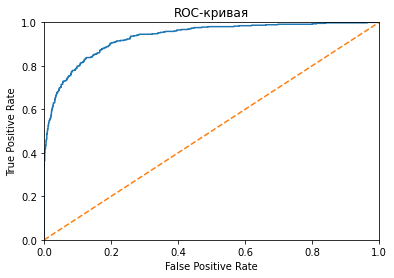

In [129]:
fpr, tpr, thresholds = roc_curve(y_test, model_cat_gscv.best_estimator_.predict_proba(X_test_scaled)[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Вывод

Итоговые результаты модели CatBoostClassifier с отмасштабированными признаками - площадь под ROC кривой на тестовой выборки составляет 0.93. Точность 86,6%.

Наиболее значимым признаком является период использования услуг. Второй по значимости признак - сколько клиент всего заплатил компании. 

## Отчёт

Был проведён исследовательский анализ данных, в ходе которого был выяснен дисбаланс классов. Кроме того, на этом этапе бвли построены графики, показывающие разницу распределения каждой фичи среди ушедших клиентов и всех клиентов. Были удалены столбцы с датами и добавлен новый столбец с периодом пользования услугами, который в результате оказался наиболее значимым признаком для итоговой модели. Было произведено кодирование категориальных признаков. При помощи кросс-валидации были сравнены три модели. Помимо этого, для модели, показавшей наивысший скор, было отдельное сравнение её результатов на отмасштабированных и неотмасштабированных данных. Фичи, оказавшиеся наименее значимыми, так же были удалены. 

***Какие пункты плана были выполнены, а какие — нет (поясните почему)?***

 * Были выполнены все пункты плана, поскольку план был составлен достаточно базоовый и включал в себя все основные шаги работы с подбором моделей и улучшением метрики


***Какие трудности возникли и как вы их преодолели?***

 * Трудности были с тем, чтобы сделать метрику максимально высокой - на это потребовалось достаточно много времени. Справиться с трудностью помогла идея о том, что можно попробовать предсказывать вероятность ухода
 * Возникли трудности в момент, когда на этапе исследовательского анализа данных многие признаки казались неинформативными, были не понятно, какие стоит использовать, какие нет. Эта проблема была решена при помощи встроенного в CatBoost метода, показывающего информативность признаков

***Какие ключевые шаги в решении задачи выделили?***
 * Загрузка и первичный осмотр данных
 * Предобработка 
 * Исследовательский анализ данных 
 * Кодирование и масштабирование данных
 * Обучение моделей и подбор гипер-параметров
 * Анализ важности признаков
 * Тестирование лучшей модели

***Какая ваша итоговая модель и какое у неё качество?***

* Итоговая модель: CatBoostRegressor с гипер-параметрами: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1200}, обученная на закодированных и отмасштабированных признаках (исключая признаки с датой (вместо них признак с периодом) и исключая следующие признаки:'payment_method_Credit card (automatic)', 'device_protection', 'online_backup', 'dependents').
 * ROC-AUC получившейся модели на тестовой выборке 0.93, а accuracy=0.866